In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
#Calculamos el cociente de semiejes c/a y sigma_z/sigma_total
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import tenform as ten
from numpy import linalg

h=0.732
fo=open('/home/ornela/python/semiejes.dat','w')
vector = ('00','01','03','09','13','14','18','19','20','21')

snapshot=range(497,496,-1)
for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    for i in range(0,10):
        pstr = snap['subhalo_0'+ str('%s'%vector[i]) +'/Str/Coordinates'].value
        cm   = snap['subhalo_0'+ str('%s'%vector[i]) +'/Center'].value
        vel  = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Velocities'].value
        masa = snap['subhalo_0'+ str('%s'%vector[i]) +'/Str/Masses'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value
        
#---------paso las coordenadas respecto al centro de la galaxia-------
        xstr = (pstr[:,0]-cm[0])/h
        ystr = (pstr[:,1]-cm[1])/h
        zstr = (pstr[:,2]-cm[2])/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
        
#---------------masas------------------------------------------        
        masa = masa/h
        
        rgal=0.15*r200
        
        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])
                
        Mc = np.cumsum((masa[limit])[r_indice])
        Mgal = Mc[-1]
               
        razon = Mc/Mgal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)
        
        r90 = r_sort[noventa]
        r50 = r_sort[cincuenta]
#------------------------------------------------------------------        
##esto sirve si quiero hacer una submuestra de mi conjunto de datos
       
        veloc,=np.where(r<r50[-1])
        
#----------componentes de la velocidad del centro de masa------------
        vxcm = sum(masa[veloc]*vel[veloc,0])/sum(masa[veloc])
        vycm = sum(masa[veloc]*vel[veloc,1])/sum(masa[veloc])
        vzcm = sum(masa[veloc]*vel[veloc,2])/sum(masa[veloc])
        
#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = vel[:,0] - vxcm
        vy = vel[:,1] - vycm
        vz = vel[:,2] - vzcm
        
# utilizo una matriz de rotacion de modo que el plano xy coincida aprox con el plano del disco
# rot.rot, el primer rot es como yo le llamo arriba cuando importo, el segundo rot tiene que ver
#con como se llama la funcion adentro del archivo rotation
        if isnap == 497: 
            e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa,xstr,ystr,zstr,vx,vy,vz,r90[-1])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz
        
#----------calculamos las dispersiones de velocidades---------------------
        n=len(vxn) #la longitud es la misma para los 3
        vx_prom = sum(vxn)/n
        vy_prom = sum(vyn)/n
        vz_prom = sum(vzn)/n
        
        sigma_x = np.sqrt(sum((vxn-vx_prom)**2)/n)
        sigma_y = np.sqrt(sum((vyn-vy_prom)**2)/n)
        sigma_z = np.sqrt(sum((vzn-vz_prom)**2)/n)
        
        sigma_total = np.sqrt(sigma_x**2 + sigma_y**2 + sigma_z**2)
        
        C1 = sigma_z/sigma_total
        
        
#--------calculamos el tensor de inercia------------------------
        limit,=np.where(r<r90[-1])
        tensor = ten.tenfr(xn[limit], yn[limit], zn[limit], masa[limit])

#queremos sacar los autovalores
        e = linalg.eig(tensor)
        autov = e[0]
        w = sort(autov)
        a = w[2]
        c = w[0]
        
        #print a, c 
        
        C2 = c/a
        
        print C2, C1
        
        fo.write(str('%12.6f'% C1)+'\t'+
            str('%12.6f'% C2)+'\n')
        fo.flush()
        
    

0.374636 0.466159909037
0.445766 0.455874649558
0.327409 0.414746303033
0.605284 0.540829049167
0.510794 0.542574089475
0.579624 0.519531056246
0.528308 0.49530172366
0.70044 0.543472610072
0.911232 0.577516117343
0.689228 0.596385806143


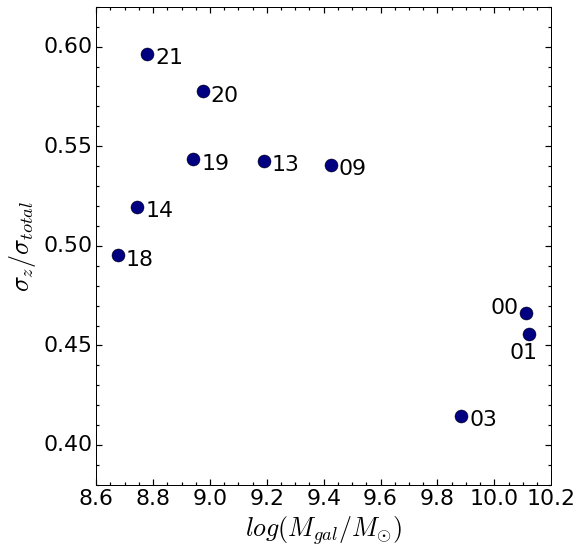

In [17]:
# Graficamos sigma vs Mgal
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot


import matplotlib.pyplot as plt
vector = ('00','01','03','09','13','14','18','19','20','21')
cm1=np.loadtxt('/home/ornela/python/parametros.dat')
cm2=np.loadtxt('/home/ornela/python/semiejes.dat')

Mgal =cm1[:,4]
sigma =cm2[:,0]

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax1=fig.add_subplot(111)
ax1.plot(Mgal,sigma,'o', markersize=13, color='navy')
ax1.set_ylim(0.38,0.62)
#ax1.set_xlim(10,12)
ax1.minorticks_on()
ax1.tick_params( labelsize=22)
ax1.tick_params('both', length=3, width=1.2,which='minor')
ax1.tick_params('both', length=6, width=1.2,which='major')  
ax1.set_ylabel(r'$\sigma_{z} / \sigma_{total}$', fontsize=26)
ax1.set_xlabel(r'$log(M_{gal}/M_{\odot})$', fontsize=26)
for i in range(0,10):
    if vector[i] == '00':
        plt.annotate(str('%s'%vector[i]), xy=(Mgal[i],sigma[i]), 
                     xytext=(-35, 0), textcoords='offset points', fontsize=22)
    elif vector[i] == '01':
        plt.annotate(str('%s'%vector[i]), xy=(Mgal[i],sigma[i]), 
                     xytext=(-20, -25), textcoords='offset points', fontsize=22)
    else:
        plt.annotate(str('%s'%vector[i]), xy=(Mgal[i],sigma[i]), 
                     xytext=(+8, -10), textcoords='offset points', fontsize=22)

fig.savefig('Mgal_vs_sigma.png', dpi = 80)
plt.show()


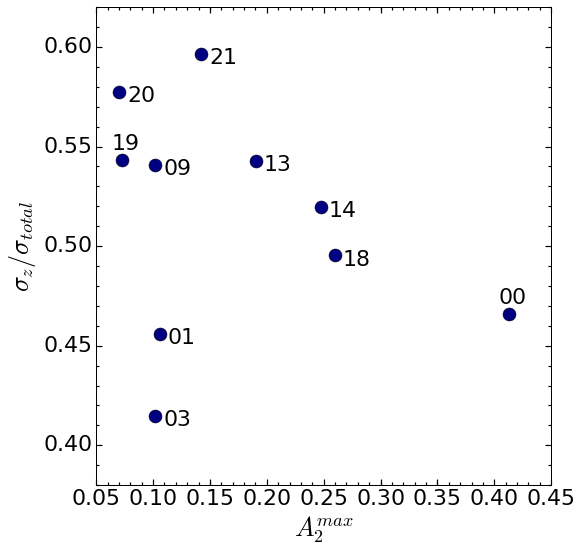

In [24]:
# Graficamos sigma vs A2max
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot


import matplotlib.pyplot as plt
vector = ('00','01','03','09','13','14','18','19','20','21')
cm1=np.loadtxt('/home/ornela/python/parametros.dat')
cm2=np.loadtxt('/home/ornela/python/semiejes.dat')

A2max =cm1[:,7]
sigma =cm2[:,0]

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax1=fig.add_subplot(111)
ax1.plot(A2max,sigma,'o', markersize=13, color='navy')
ax1.set_ylim(0.38,0.62)
#ax1.set_xlim(10,12)
ax1.minorticks_on()
ax1.tick_params( labelsize=22)
ax1.tick_params('both', length=3, width=1.2,which='minor')
ax1.tick_params('both', length=6, width=1.2,which='major')  
ax1.set_ylabel(r'$\sigma_{z} / \sigma_{total}$', fontsize=26)
ax1.set_xlabel(r'$A_{2}^{max}$', fontsize=26)
for i in range(0,10):
    if vector[i] == '00'or vector[i] == '19':
        plt.annotate(str('%s'%vector[i]), xy=(A2max[i],sigma[i]), 
                     xytext=(-10, +10), textcoords='offset points', fontsize=22)
    else:
        plt.annotate(str('%s'%vector[i]), xy=(A2max[i],sigma[i]), 
                     xytext=(+8, -10), textcoords='offset points', fontsize=22)

fig.savefig('A2max_vs_sigma.png', dpi = 80)
plt.show()

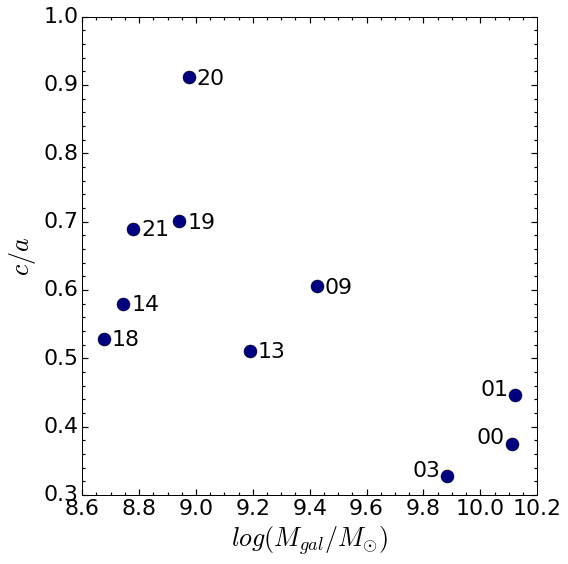

In [27]:
# Graficamos c/a vs Mgal
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot


import matplotlib.pyplot as plt
vector = ('00','01','03','09','13','14','18','19','20','21')
cm1=np.loadtxt('/home/ornela/python/parametros.dat')
cm2=np.loadtxt('/home/ornela/python/semiejes.dat')

Mgal =cm1[:,4]
c_a =cm2[:,1]

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax1=fig.add_subplot(111)
ax1.plot(Mgal,c_a,'o', markersize=13, color='navy')
#ax1.set_ylim(8.5,10.3)
#ax1.set_xlim(10,12)
ax1.minorticks_on()
ax1.tick_params( labelsize=22)
ax1.tick_params('both', length=3, width=1.2,which='minor')
ax1.tick_params('both', length=6, width=1.2,which='major')  
ax1.set_ylabel(r'$c/a$', fontsize=26)
ax1.set_xlabel(r'$log(M_{gal}/M_{\odot})$', fontsize=26)
for i in range(0,10):
    if vector[i] == '00'or vector[i] == '01' or vector[i] == '03':
        plt.annotate(str('%s'%vector[i]), xy=(Mgal[i],c_a[i]), 
                     xytext=(-35, 0), textcoords='offset points', fontsize=22)
    else:
        plt.annotate(str('%s'%vector[i]), xy=(Mgal[i],c_a[i]), 
                     xytext=(+8, -7), textcoords='offset points', fontsize=22)

fig.savefig('Mgal_vs_ca.png', dpi = 80)
plt.show()

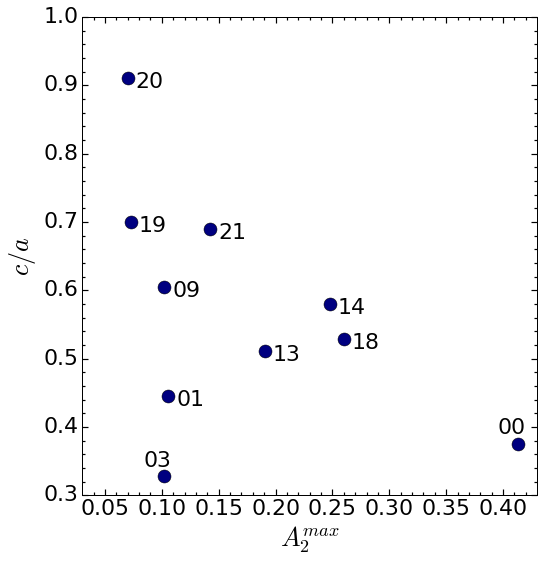

In [31]:
# Graficamos c/a vs A2max
#r50, r90, rgal, M90, Mgal, Mgas, Mvir, A2max, Rmax, krot


import matplotlib.pyplot as plt
vector = ('00','01','03','09','13','14','18','19','20','21')
cm1=np.loadtxt('/home/ornela/python/parametros.dat')
cm2=np.loadtxt('/home/ornela/python/semiejes.dat')

A2max=cm1[:,7]
c_a =cm2[:,1]

fig=plt.figure(1, figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax1=fig.add_subplot(111)
ax1.plot(A2max,c_a,'o', markersize=13, color='navy')
ax1.set_xlim(0.03,0.43)
#ax1.set_xlim(10,12)
ax1.minorticks_on()
ax1.tick_params( labelsize=22)
ax1.tick_params('both', length=3, width=1.2,which='minor')
ax1.tick_params('both', length=6, width=1.2,which='major')  
ax1.set_ylabel(r'$c/a$', fontsize=26)
ax1.set_xlabel(r'$A_{2}^{max}$', fontsize=26)
for i in range(0,10):
    if vector[i] == '00' or vector[i] == '03':
        plt.annotate(str('%s'%vector[i]), xy=(A2max[i],c_a[i]), 
                     xytext=(-20, +10), textcoords='offset points', fontsize=22)
    else:
        plt.annotate(str('%s'%vector[i]), xy=(A2max[i],c_a[i]), 
                     xytext=(+8, -10), textcoords='offset points', fontsize=22)

fig.savefig('A2max_vs_ca.png', dpi = 80)
plt.show()